En esta NB implementé el algoritmo de llenado por convergencia, es decir, que se repite el bucle hasta que en dos vueltas los voxeles de cloud están exactamente igual etiquetados. Parece que lo conseguí pero el resultado no me encanta, porque hace que se llene todo de la clase más abundante, más que esa cercanía o estructura de capas que busco...idk

In [18]:
import tables as tb
import pandas as pd
import numpy as np
import collections
from collections import namedtuple


from labelling.MClabelling import labelling_MC
from utils.labelling_utils import voxel_labelling_MC
from utils.histogram_utils import bin_creator, container_creator, mcimg
from utils.data_utils      import histog_to_coord
from utils.plotting_utils  import plot_3d_vox, plot_3d_hits

from utils.beersheba_labelling_utils import voxelize_beersh, merge_MC_beersh_voxels

from invisible_cities.io   import dst_io as dio

In [2]:
cutnum, num = '24', '6206'
directory   = '/Users/mperez/NEXT/bersh_prod/prod_example/Tl208_NEW_v1_03_01_nexus_v5_03_04_cut{cut}.beersheba_{num}.root.h5'.format(cut = cutnum, num = num)

total_size  = (440, 440, 550) 
voxel_size  = (5, 5, 5) #equivalent to step
start_bin   = (-220, -220, 0) #equivalent to x0

In [3]:
detector_frame = container_creator(total_size, voxel_size)
detector_bins  = bin_creator(detector_frame, steps = voxel_size, x0 = start_bin)

In [4]:
labelled_voxels = labelling_MC(directory, total_size, voxel_size, start_bin, blob_ener_loss_th = 0.25)

beersh_voxels = voxelize_beersh(directory, total_size, voxel_size, start_bin, labelled_vox = labelled_voxels)

mc_beersh_voxels = merge_MC_beersh_voxels(labelled_voxels, beersh_voxels)

In [5]:
def moves(ndim):
    '''
    Function that returns all the movements from one voxel to its neighbours (we consider a neighbour if a part of
    the voxel touches another, i.e. for 3dim faces are first neighbours, edges are second and vertex are third, and
    we consider them all).
    
    Args:
        ndim: INT
    Number of dimensions of the movements.
    
    RETURNS:
        vs: LIST
    Contains all the posible unitary movements to the neighbours.
    '''
    u0 = np.zeros(ndim)
    def u1(idim):
        ui1 = np.zeros(ndim)
        ui1[idim] = 1
        return ui1.astype(int)

    vs = (u0, u1(0), -1 * u1(0))
    for idim in range(1, ndim):
        us = (u0, u1(idim), -1 * u1(idim))
        vs = [(vi + ui).astype(int) for vi in vs for ui in us]
    vs.pop(0)

    return vs

In [6]:
def assign_nlabels(label_dict = {'rest':1, 'track':2, 'blob':3}, 
                   corresp_label_dict = {'nrest':'rest', 'ntrack':'track', 'nblob':'blob'}):
    '''
    Creates a dictionary that links the pure segclasses with their neighbour ones.
    
    Args:
        label_dict: DICT
    Has the original class names with their corresponding number.
    
        corresp_label_dict: DICT
    Has the correspondance between the neighbour class names and the pure class names.
    
    RETURNS:
        nlabel_dict: DICT
    Has the correspondance between pure seclass number and neighbour segclass number.
    '''
    
    nlabel_dict = {}
    for nclass in corresp_label_dict.keys():
        label = label_dict[corresp_label_dict[nclass]]
        nlabel_dict[label] = label + len(label_dict) #le sumo el numero de etiquetas que hay... que obviamente son 3 para nosotros
    return nlabel_dict

In [7]:
nlabel_dict = assign_nlabels()

In [8]:
def scale_bins(bins, voxel_size):
    '''
    Scales the detector bins to unitary bins. If the input are already unitary bins, it does nothing.
    
    Args:
        bins: LIST OF ARRAYS
    Usually, detector bins to be normalized.
    
        voxel_size: TUPLE
    Size of the voxels in each dimension.
    
    RETURNS:
        bins: LIST OF ARRAYS
    Returns the unitary bins.
    '''
    size = [abs(b[1] - b[0]) for b in bins]
    is_scaled = [True if s == 1 else False for s in size]
    if not np.array(is_scaled).any():
        bins = [b / s for b, s in zip(bins, voxel_size)]
    return bins

In [163]:
event = mc_beersh_voxels[mc_beersh_voxels.event_id == mc_beersh_voxels.event_id.unique()[2]]

In [164]:
coords = np.array(event[['x', 'y', 'z']])
bins = [b / s for b, s in zip(detector_bins, voxel_size)]
segm_beersh_histo, _ = np.histogramdd(coords, bins)
ndim = segm_beersh_histo.ndim
voxel_positions = segm_beersh_histo.nonzero()

In [165]:
cloud_coords = event[event.segclass.isnull()][['x', 'y', 'z']]

Hago un cloud mask FUERA del loop porque siempre es el mismo, rollo los voxeles cloud son los mismos siempre :)

Antes como trabajaba solo con los no nulos pues la mask la hacía dentro del loop

In [166]:
cloud_mask = event.segclass.isnull()

In [167]:
sum(cloud_mask)

88

In [322]:
cosa = pd.DataFrame()

In [324]:
voxel_segclass.equals(cosa)

False

# STARTS THE LOOP

In [336]:
voxel_segclass = event.segclass
seg_unique = voxel_segclass.unique()
seg_unique = np.sort(seg_unique[~np.isnan(seg_unique)])
seg_unique

array([1., 2., 3., 4., 5.])

In [337]:
nbour_counts = []
for seg in seg_unique:
    #Create an empty histogram for each class to fill
    counts = np.zeros(detector_frame.shape)
    #Create the mask for the specific class
    segclass_mask = voxel_segclass == seg
    #Now we select the coords that have that specific class 
    selected_coor = coords[segclass_mask]
    for move in moves(ndim):
        #We use norm coordinates, so it is not necessary to add the step to move the coordinates
        coors_next     = selected_coor + move
        #We count how many of one specific segclass are in that move
        counts_next, _ = np.histogramdd(coors_next, bins)
        #We add to the empty histogram the counts, in each step will be adding for a new move...
        counts         = counts + counts_next
    #Finally we select the values of the beersheba coordinates (because when moving we filled non existing voxels)
    
    nbour_counts.append(counts[voxel_positions])

In [338]:
sum(cloud_mask)

88

In [339]:
class_scores = np.array(nbour_counts).T[cloud_mask]

In [340]:
len(class_scores) == sum(cloud_mask)

True

Ahora, elimino igualmente los emptys y por ahora el resto los labeleo. Más adelante quizás probar eso de eliminar tb los que no alcancen cierto número en el score comparado con el número de vecinos que tienen... Pero por ahora nanai

In [341]:
empty_positions = [i for i, score in enumerate(class_scores) if (score == np.zeros(len(score))).all()]
empty_positions

[]

In [342]:
valor_final = len(class_scores) - len(empty_positions)
class_scores = np.delete(class_scores, empty_positions, axis = 0)

In [343]:
cloud_index = voxel_segclass[cloud_mask].index
cloud_index

Int64Index([321, 322, 323, 324, 325, 328, 330, 331, 332, 333, 334, 338, 340,
            341, 342, 343, 344, 346, 347, 349, 351, 352, 353, 354, 355, 356,
            357, 358, 359, 360, 361, 362, 364, 365, 366, 367, 368, 371, 373,
            374, 377, 380, 383, 384, 385, 386, 387, 388, 389, 391, 392, 393,
            394, 395, 396, 397, 402, 403, 408, 409, 410, 411, 413, 416, 420,
            422, 423, 424, 426, 427, 429, 430, 431, 433, 434, 440, 441, 442,
            443, 444, 446, 447, 449, 450, 451, 452, 453, 454],
           dtype='int64')

Aquí no debería cambiar la cloud mask original porque como la hago fuera y quiero que no cambie, para siguientes loops estamos jodidos entonces

Entonces hago una copia que sería de los voxeles de cloud, aquellos que sí están llenos, que tienen un score...

In [344]:
cloud_mask_full = cloud_mask.copy()

In [345]:
cloud_mask_full[cloud_index[empty_positions]] = ~cloud_mask[cloud_index[empty_positions]]

In [346]:
sum(cloud_mask), sum(cloud_mask_full)

(88, 88)

In [347]:
valor_final == len(class_scores)

True

In [348]:
len(class_scores) == sum(cloud_mask_full)

True

In [349]:
class_values = [np.where(score == score.max())[0].max() + 1 for score in class_scores]

In [350]:
nclass_values = [nlabel_dict[classv] if np.isin(classv, list(nlabel_dict.keys())) else classv for classv in class_values] #we could just add 3 to each value but it seems 

In [351]:
nclass_df = pd.DataFrame({'segclass':nclass_values}, index = voxel_segclass[cloud_mask_full].index)

In [352]:
event = event.merge(nclass_df, left_index=True, right_index=True, how = 'outer')

In [353]:
event['segclass'] = event['segclass_y'].fillna(event['segclass_x'])
event = event.drop(['segclass_x', 'segclass_y'], axis = 1)

In [354]:
sum(event.segclass.isnull()) == len(empty_positions)

True

In [355]:
voxel_segclass.equals(event.segclass) #es decir, las segclass que tuve a la entrada son iguales que ahora a la 
#salida? si es falso, sigue el loop... esto sería básicamente mi idea!!! (comparar esto con un while no es trivial
#ahora mismo pero fijo q es facil y no me cosco) Entonces ahora se actualizaría la variable y a iterar again :)

True

In [425]:
event.segclass = pd.to_numeric(event.segclass, downcast = 'integer')

In [426]:
sum(voxel_segclass)

490.0

In [427]:
sum(event.segclass)

490

In [9]:
def count_neighbours(voxel_segclass, coords, bins):
    '''
    Counts the number of neighbours of each class a voxel has. The neighbour count is performed by moving all 
    the voxels a certain position. For each class, the function will make N movements to all the neighbours 
    (26 for 3 dimensional data), in each movement it performs an histogram to count. We add the histograms 
    corresponding to the same class in each step, and finally select the desired voxels (only those that exist 
    in the event, i.e. that have a beersheba energy associated).
    
    Args:
        voxel_segclass: PANDAS SERIES
    Segclass column of the event dataframe to know which classes are going to participate in the counting.
    
        coords: NUMPY ARRAY
    Has the coordinates of the beersheba voxels. It's shaped as (N, d), with N the number of voxels and d the 
    dimensions.
    
        bins: LIST OF ARRAYS
    Normalized bins for each dimension.
    
    RETURNS:
        nbour_counts: LIST
    Has the number of neighbour voxels per class one voxel has. It is a list of arrays, where each array 
    corresponds to a class (the first position is the class 1 - rest, etc).
    '''
    
    model_histo, _ = np.histogramdd(coords, bins)
    #This is like creating a mask for the positions of the voxels, for the count
    voxel_positions = model_histo.nonzero() 
    #Take the segclass values, deleting NaN
    seg_unique = voxel_segclass.unique()
    seg_unique = np.sort(seg_unique[~np.isnan(seg_unique)])
    #List to append neighbour counts for each segclass
    nbour_counts = []
    for seg in seg_unique:
        #Create an empty histogram for each class to fill
        counts = np.zeros(model_histo.shape)
        #Create the mask for the specific class
        segclass_mask = voxel_segclass == seg
        #Now we select the coords that have that specific class 
        selected_coor = coords[segclass_mask]
        ndim = len(bins)
        for move in moves(ndim):
            #We use norm coordinates, so it is not necessary to add the step to move the coordinates
            coors_next     = selected_coor + move
            #We count how many of one specific segclass are in that move
            counts_next, _ = np.histogramdd(coors_next, bins)
            #We add to the empty histogram the counts, in each step will be adding for a new move...
            counts         = counts + counts_next
        #Finally we select the values of the beersheba coordinates (because when moving we filled non existing voxels)
        nbour_counts.append(counts[voxel_positions])
    return nbour_counts

In [24]:
def fill_df_with_nbours_converging(mc_beersh_event, cloud_mask, nbour_counts, nlabel_dict):
    '''
    This function takes the neighbour counts scores for each empty voxel and assigns them their correspondent 
    neighbour class. If one voxel has no scores, it's ignored and remains empty (will be filled afterwards,
    looping on this function). If two classes are tied, the function chooses the most important one.
    (blob > track > rest). 
    This converging function will always label the cloud voxels (those that aren't filled with pure segclass),
    taking on account all the labelled voxels. 
    
    Args:
        mc_beersh_event: DATAFRAME
    Contains one event from the merge_MC_beersh_voxels function output.
    
        cloud_mask: PANDAS SERIES
    Mask for the beersheba voxels that are not filled with primary classes.
          
        nbour_counts: LIST
    Output of the count_neighbours function, which has the number of neighbour voxels per class one voxel has.
    It is a list of arrays, where each array corresponds to a class (the first position is the class 1 - rest, etc).
    Each array has the counts of the number of neighbours for every beersheba voxel.
        
        nlabel_dict: DICT
    Contains the segclass correspondances between the main and the neighbour class.
        
    RETURNS:
        mc_beersh_event: DATAFRAME
    The event's segclass column is filled with the desired classes. It has the same structure as the input one.
    '''
    
    #We take the segclass column
    voxel_segclass = mc_beersh_event.segclass

    #Score for each segclass (number of neighbors that a voxel has of each class)
    class_scores = np.array(nbour_counts).T[cloud_mask]  
    assert len(class_scores) == sum(cloud_mask), 'Something failed in the count_neighbours function'
        
    empty_positions = [i for i, score in enumerate(class_scores) if (score == np.zeros(len(score))).all()]
    final_val = len(class_scores) - len(empty_positions) #to check things
        
    #Deleting the ones empty
    class_scores = np.delete(class_scores, empty_positions, axis = 0)
    assert final_val == len(class_scores), 'Something failed with the empty count voxels'
        
    #Index of the null segclass values (the ones with true in the mask ofcourse)
    cloud_index = voxel_segclass[cloud_mask].index
    
    #Copy the cloud mask to delete the empty ones
    cloud_mask_full = cloud_mask.copy()
    
    #Changing the mask to ignore the ones empty
    cloud_mask_full[cloud_index[empty_positions]] = ~cloud_mask_full[cloud_index[empty_positions]]
    assert len(class_scores) == sum(cloud_mask_full), 'Something failed excluding empty values of the dataframe'
        
    #Take the position of the most counted segclass; in case of ties, it chooses the most important (3>2>1)
    class_values = [np.where(score == score.max())[0].max() + 1 for score in class_scores]
        
    #Transforms the pure classes into neighbour classes; if it's already a neighbour it stays this way
    nclass_values = [nlabel_dict[classv] if np.isin(classv, list(nlabel_dict.keys())) else classv for classv in class_values]
        
    #DF with the new labelled voxels, with the same indexes as the original DF
    nclass_df = pd.DataFrame({'segclass':nclass_values}, index = voxel_segclass[cloud_mask_full].index)
    
    #Join DF and do cleaning
    mc_beersh_event = mc_beersh_event.merge(nclass_df, left_index=True, right_index=True, how = 'outer')
    mc_beersh_event['segclass'] = mc_beersh_event['segclass_y'].fillna(mc_beersh_event['segclass_x'])
    mc_beersh_event = mc_beersh_event.drop(['segclass_x', 'segclass_y'], axis = 1)
    assert sum(mc_beersh_event.segclass.isnull()) == len(empty_positions), 'Something failed excluding the empy voxels'
    
    return mc_beersh_event

In [25]:
def label_neighbours_converging(mc_beersh_event, bins, voxel_size, nlabel_dict):
    '''
    Takes an event of beersheba primary labelled (only with the main segclass) and assigns neighbour 
    classes to the empty voxels.
    This converging function will loop filling the cloud voxels until two consecutive loops the labelling matches.
    In this way, in the first loop the cloud voxels are filled taking into account just the voxels with pure class,
    as there is no other class yet. However, in the second loop there are neighbour labels already, so some of the 
    voxels now are surrounded by those voxels rather than a few with pure segclass.
    The pure segclass voxels remain untouched always.
    
    Args:
        mc_beersh_event: DATAFRAME
    Contains one event from the merge_MC_beersh_voxels function output.
    
        bins: LIST OF ARRAYS
    Detector bins, although they will be scaled to unity bins to work in this function.
        
        voxel_size: TUPLE
    Size in each dimension for the voxels.    
        
        nlabel_dict: DICT
    Contains the segclass correspondances between the main and the neighbour class.
        
    RETURNS
        mc_beersh_event: DATAFRAME
    The event's segclass column is filled with the desired classes. It has the same structure as the input one.
    '''
    
    coords = np.array(mc_beersh_event[['x', 'y', 'z']])
    bins = scale_bins(bins, voxel_size) 
    
    cloud_mask = mc_beersh_event.segclass.isnull() #this is the permanent mask for the 
    voxel_segclass = mc_beersh_event.segclass #we can assign this because the loop will start always if there is any nan
    
    #While will run if there is any NaN in the voxel_segclass (this is soon fixed), or if it has not converged
    while not mc_beersh_event.segclass.equals(voxel_segclass) or sum(voxel_segclass.isnull()) != 0:
        voxel_segclass  = mc_beersh_event.segclass #update the condition
        nbour_counts    = count_neighbours(voxel_segclass, coords, bins)
        mc_beersh_event = fill_df_with_nbours_converging(mc_beersh_event, cloud_mask, nbour_counts, nlabel_dict)
        
    #Turn into an integer
    mc_beersh_event.segclass = pd.to_numeric(mc_beersh_event.segclass, downcast = 'integer')
    return mc_beersh_event

In [12]:
mc_beersh_event = mc_beersh_voxels[mc_beersh_voxels.event_id == mc_beersh_voxels.event_id.unique()[2]]

In [13]:
final_event = label_neighbours_new(mc_beersh_event, detector_bins, voxel_size, nlabel_dict)

In [435]:
event.equals(final_event)

True

In [20]:
cloud    = final_event[np.isin(final_event.segclass, (4, 5, 6))]
mc_label = final_event[np.isin(final_event.segclass, (1, 2, 3))]

In [26]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

def plot_cloud_voxels(cloud, mc_label, cloud_value='segclass', mc_value = 'segclass', coords = ['x', 'y', 'z'], th=0, edgecolor='k', linewidth = .3, cmap=mpl.cm.jet, opacity = 1):
    '''
    Funcion un pouco trapalleira...
    '''
    #Escojo el minimo y el maximo por coordenada de ambos DF, ya que si no un df se desplaza respecto a otro (probablemente)
    #De esta forma, el ''frame'' que calcula (nbins en cada coord) será el máximo siempre, y a las coordenadas a rellenar
    #le restamos el mínimo de ambos DF ya que si le restamos a cada uno por su cuenta se desplza que era lo que me pasaba
    #Entonces creo que con esto ya está la verdad
    xmin, xmax = min(cloud[coords[0]].min(), mc_label[coords[0]].min()), max(cloud[coords[0]].max(), mc_label[coords[0]].max())
    ymin, ymax = min(cloud[coords[1]].min(), mc_label[coords[1]].min()), max(cloud[coords[1]].max(), mc_label[coords[1]].max())
    zmin, zmax = min(cloud[coords[2]].min(), mc_label[coords[2]].min()), max(cloud[coords[2]].max(), mc_label[coords[2]].max())
    
    nbinsX = int(np.ceil((xmax-xmin))) + 2
    nbinsY = int(np.ceil((ymax-ymin))) + 2
    nbinsZ = int(np.ceil((zmax-zmin))) + 2
    xarr = np.ones(shape=(nbinsX, nbinsY, nbinsZ))*th

    nonzeros = np.vstack([cloud[coords[0]].values-xmin,
                          cloud[coords[1]].values-ymin,
                          cloud[coords[2]].values-zmin])
    nonzeros = nonzeros.astype(int)
    xarr[tuple(nonzeros)] = cloud[cloud_value].values
    dim     = xarr.shape
    voxels  = xarr > th

    fig  = plt.figure(figsize=(15, 15), frameon=False)
    gs   = fig.add_gridspec(2, 40)
    ax   = fig.add_subplot(gs[0, 0:16], projection = '3d')
    axcb = fig.add_subplot(gs[0, 18])
    norm = mpl.colors.Normalize(vmin=mc_label.segclass.min(), vmax=cloud.segclass.max())
    m    = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

    colors = np.asarray(np.vectorize(m.to_rgba)(xarr))
    colors = np.rollaxis(colors, 0, 4)

    ax.voxels(voxels, facecolors=colors * opacity, edgecolor=edgecolor, linewidth = linewidth)
    cb_cloud = mpl.colorbar.ColorbarBase(axcb, cmap=cmap, norm=norm, orientation='vertical')

    #second time (i do separately to put opacity on cloud voxels)
    xarr = np.ones(shape=(nbinsX, nbinsY, nbinsZ))*th

    nonzeros = np.vstack([mc_label[coords[0]].values-xmin,
                          mc_label[coords[1]].values-ymin,
                          mc_label[coords[2]].values-zmin])
    nonzeros = nonzeros.astype(int)
    xarr[tuple(nonzeros)] = mc_label[mc_value].values
    dim     = xarr.shape
    voxels  = xarr > th
    #gs   = fig.add_gridspec(2, 40)
    #ax   = fig.add_subplot(gs[0, 0:16], projection = '3d')
    #axcb = fig.add_subplot(gs[0, 18])
    #norm = mpl.colors.Normalize(vmin=x.min(), vmax=xarr.max())
    #m    = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

    colors = np.asarray(np.vectorize(m.to_rgba)(xarr))
    colors = np.rollaxis(colors, 0, 4)

    ax.voxels(voxels, facecolors=colors, edgecolor=edgecolor, linewidth = linewidth)
    cb_mc = mpl.colorbar.ColorbarBase(axcb, cmap=cmap, norm=norm, orientation='vertical')
    
    ax.set_xlabel('X ')
    ax.set_ylabel('Y ')
    ax.set_zlabel('Z ')
    #cb_cloud.set_label (cloud_value)
    #cb_mc.set_label(mc_value)

    plt.show()

<IPython.core.display.Javascript object>


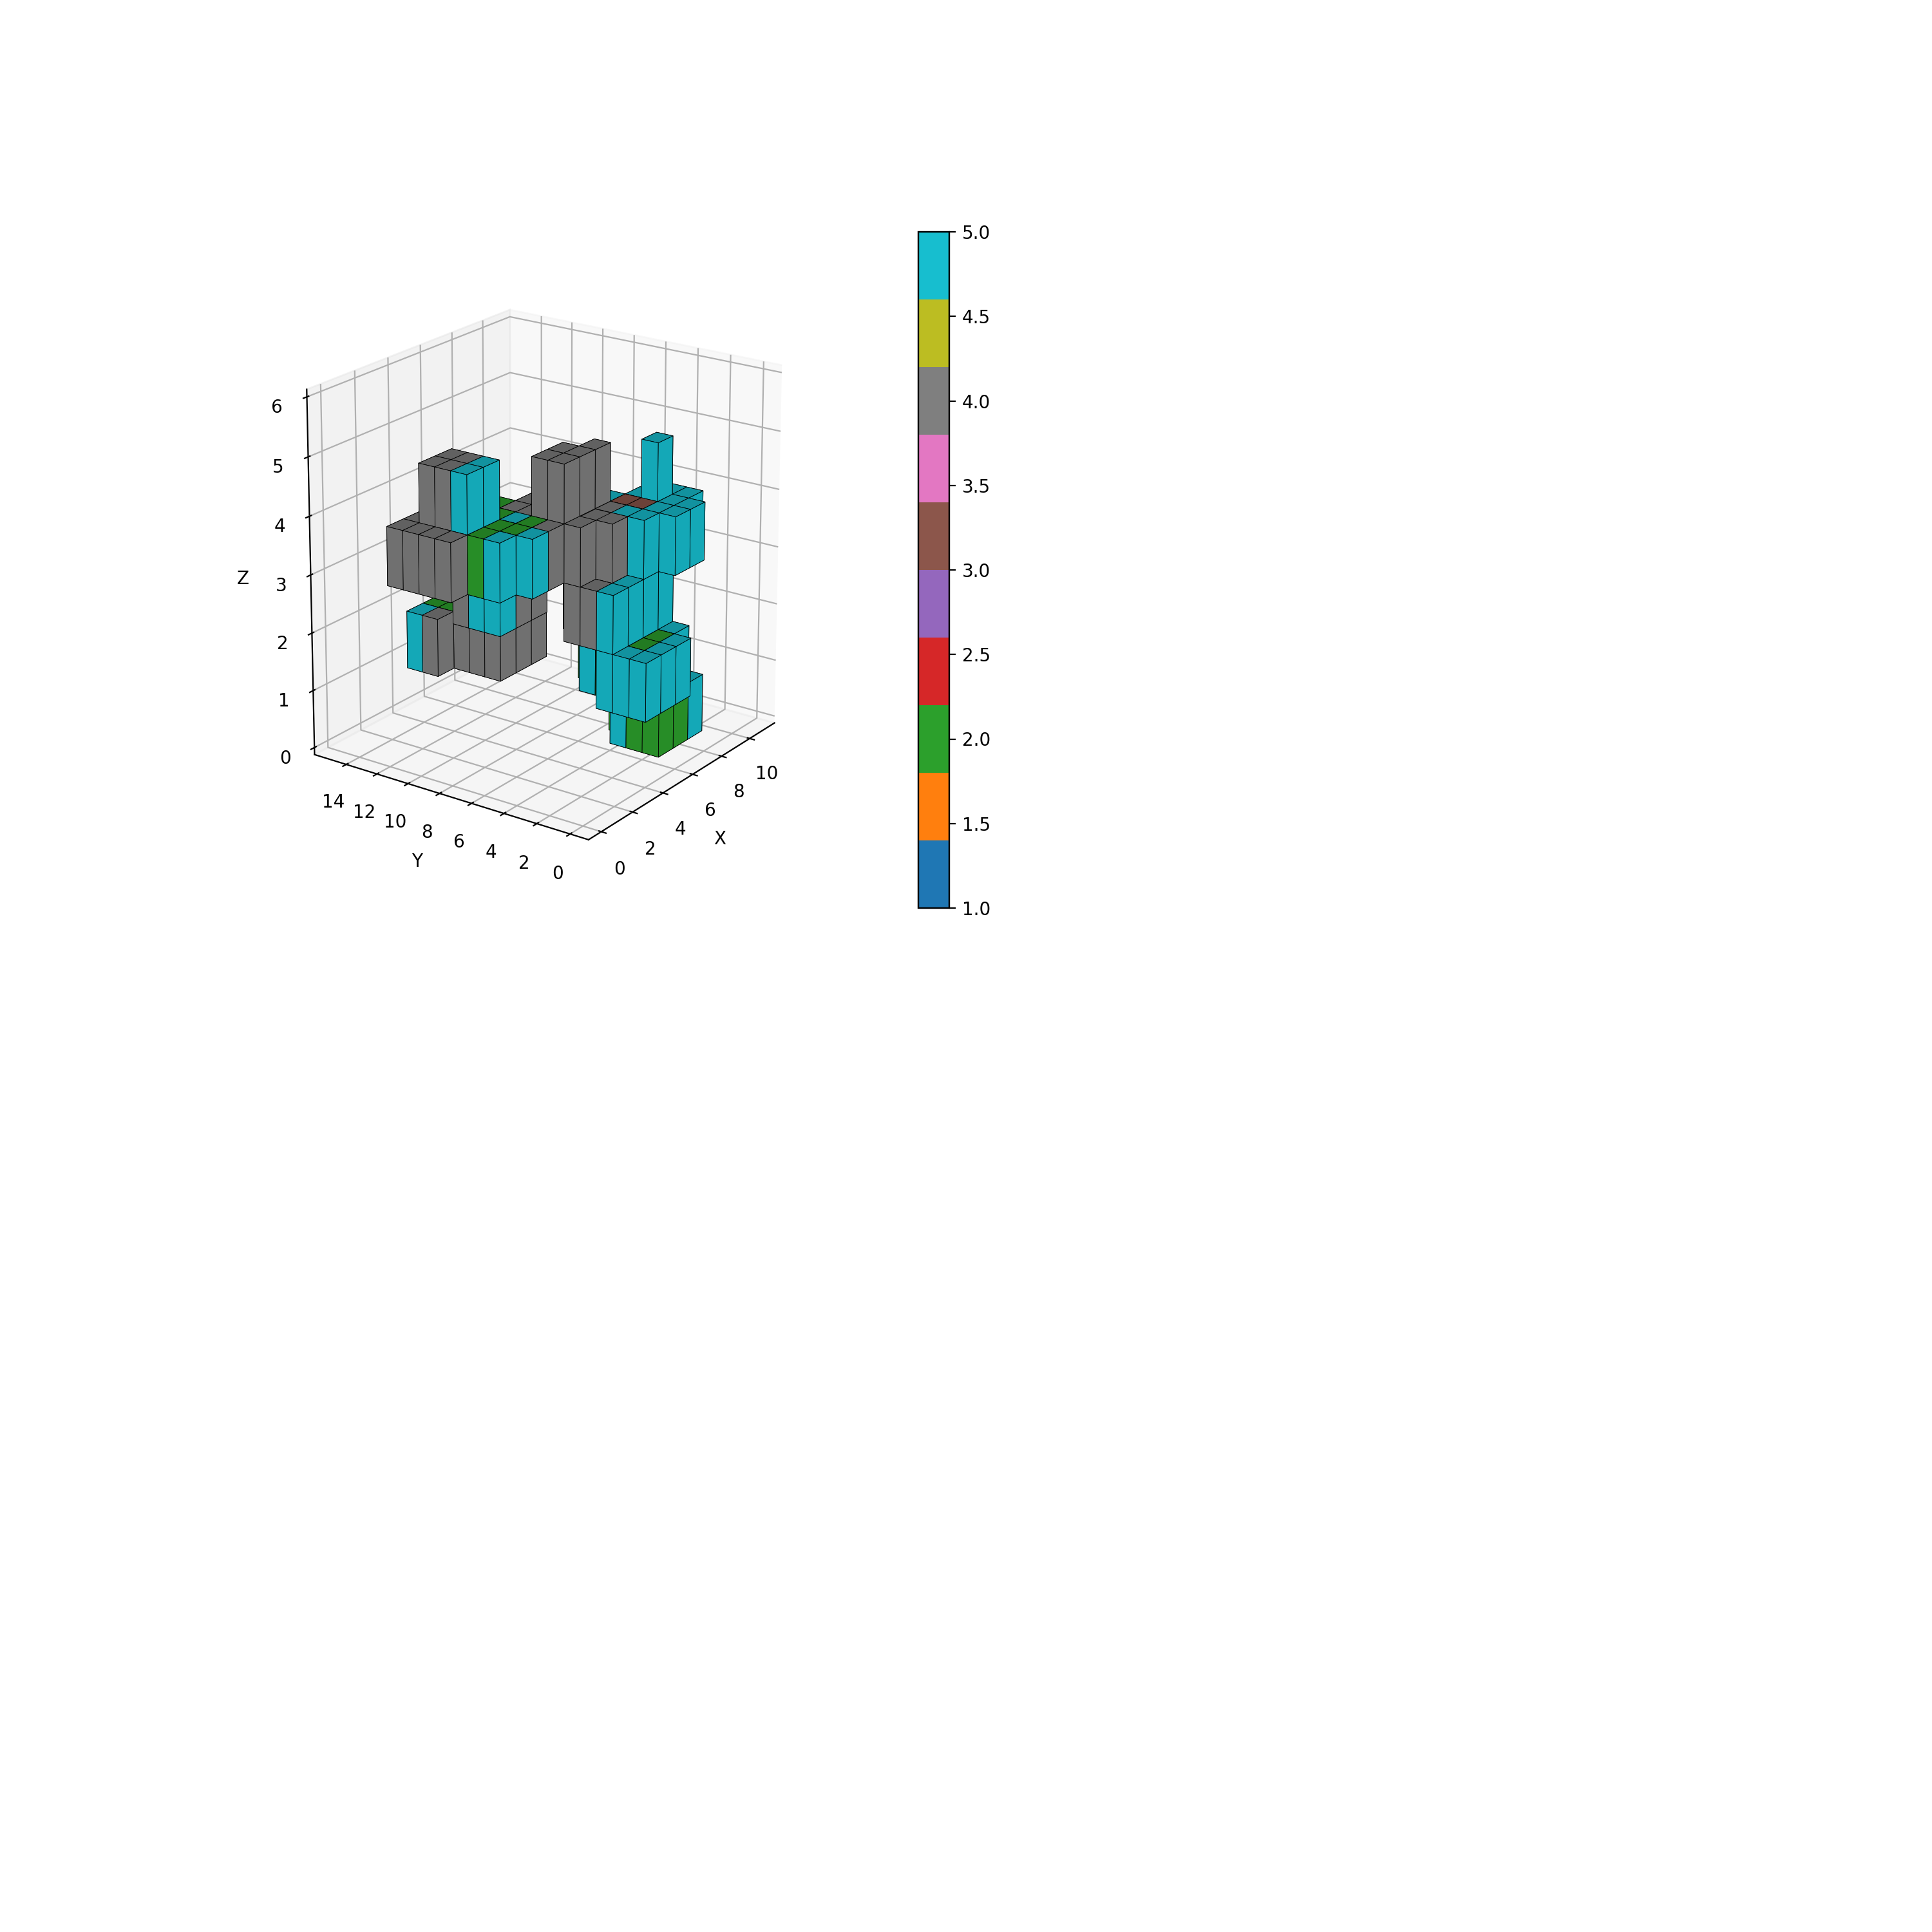

In [28]:
%matplotlib notebook
plot_cloud_voxels(cloud, mc_label, cloud_value='segclass', mc_value = 'segclass', coords = ['x', 'y', 'z'], th=0, edgecolor='k', linewidth = .3, cmap=mpl.cm.tab10, opacity = 1)



array([4, 5], dtype=int8)